<a href="https://colab.research.google.com/github/azizamirsaidova/graphanalytics/blob/main/SparkGraphXDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Graph Analytics Demo**
**Using Spark GraphX**



---


# **Spark and GraphFrames Set Up**


In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

Download the graphframes jar file from: [Graphframe jar file:](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)

Upload it in the google colab Files folder. Can be found in the left pane of this window.

In [ ]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [ ]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd
findspark.init()

spark = SparkSession.builder.master("local[*]").getOrCreate()



---
# **This notebook covers the followings:**


---


1.   **Graph Basic Attributes**


*   vertices
*   edges
*   inDegrees
*   outDegrees
*   degrees

2.   **Built-In Algorithms**

*   Connected Components
*   PageRank
*   Triangle Count
*   Label Propagation

3. **CPDB Example**


# **Graph Basic Attributes**

In [ ]:
vertices = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)], ["id", "name", "age"])

In [ ]:
edges = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

In [ ]:
g = GraphFrame(vertices, edges)

In [ ]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [ ]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [ ]:
g.vertices.count()

7

In [ ]:
g.edges.count()

8

In [ ]:
#create a function to plot the graph
import networkx as nx

def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw(g, with_labels=True, arrows = True, node_color='grey')

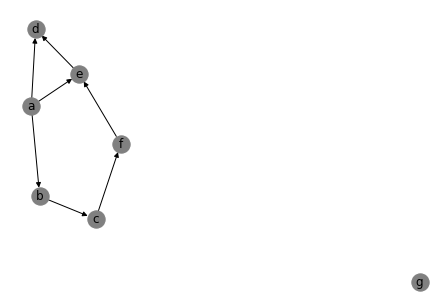

In [ ]:
plot_graph(g)

In [ ]:
# gp = nx.from_pandas_edgelist(g.edges.toPandas(),'src','dst')
# nx.draw_spectral(gp, center=["2", "5"], scale=3.1)

# ***inDegrees, outDegrees and degrees***

For example, we can identify those who has more connection by using sort function.
  
**inDegrees** is a number of head ends adjacent to a vertex.


In [ ]:
g.inDegrees.sort(['inDegree'],ascending=[0]).show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       2|
|  f|       1|
|  e|       1|
|  a|       1|
|  d|       1|
+---+--------+



**outDegree** is a number of tail ends adjacent to a vertex.

In [ ]:
g.outDegrees.sort(['outDegree'],ascending=[0]).show()

+---+---------+
| id|outDegree|
+---+---------+
|  e|        2|
|  a|        2|
|  f|        1|
|  c|        1|
|  d|        1|
|  b|        1|
+---+---------+



**Degree** is just a number of edges connected to a node regardless of the direction of edge

In [ ]:
g.degrees.sort(['Degree'],ascending=[0]).show()

+---+------+
| id|degree|
+---+------+
|  c|     3|
|  e|     3|
|  b|     3|
|  a|     3|
|  f|     2|
|  d|     2|
+---+------+



# **Built-In Algorithms**


---



** *italicized text*PageRank Algorithm**:

In [ ]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)
## look at the pagerank score for every vertex
pr.vertices.show()
## look at the weight of every edge
pr.edges.show()

+---+-------+---+-------------------+
| id|   name|age|           pagerank|
+---+-------+---+-------------------+
|  g|  Gabby| 60| 0.1799821386239711|
|  f|  Fanny| 36| 0.3283606792049851|
|  e| Esther| 32|0.37085233187676075|
|  d|  David| 29| 0.3283606792049851|
|  c|Charlie| 30| 2.6878300011606218|
|  b|    Bob| 36|  2.655507832863289|
|  a|  Alice| 34|0.44910633706538744|
+---+-------+---+-------------------+

+---+---+------------+------+
|src|dst|relationship|weight|
+---+---+------------+------+
|  f|  c|      follow|   1.0|
|  e|  f|      follow|   0.5|
|  e|  d|      friend|   0.5|
|  d|  a|      friend|   1.0|
|  c|  b|      follow|   1.0|
|  b|  c|      follow|   1.0|
|  a|  e|      friend|   0.5|
|  a|  b|      friend|   0.5|
+---+---+------------+------+



In [ ]:
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank")\
.join(vertices, on="id").orderBy("pagerank", ascending=False)\
.show(10)

+---+--------------------+-------+---+
| id|            pagerank|   name|age|
+---+--------------------+-------+---+
|  b|   3.620587832361418|    Bob| 36|
|  c|   3.245249577290185|Charlie| 30|
|  a| 0.03825003895693978|  Alice| 34|
|  e|0.030638586765997688| Esther| 32|
|  f|0.026813355024876025|  Fanny| 36|
|  d|0.026813355024876025|  David| 29|
|  g| 0.01164725457570717|  Gabby| 60|
+---+--------------------+-------+---+



**Connected Components**

In [ ]:
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate(SparkConf())
sc.setCheckpointDir('/content/sample_data')
# SparkContext.setCheckpointDir(dirName= '/content/sample_data')


In [ ]:
g.connectedComponents().show()

***Label Propagation***


In [ ]:
labelp_result = g.labelPropagation(maxIter=40)

labelp_result.show()

In [ ]:
communities = g.labelPropagation(maxIter=5)
communities.persist().show(10)
print (f"There are {communities.select('label').distinct().count()} communities in sample graph.")

In [ ]:
#only shows the top 5 rows
labelp_result.groupby('label').count().sort('count', ascending=False).show(5)

Triangle Count

In [ ]:
tc_friends = g.triangleCount()
tc_friends
tc_friends.select("id", "count").show()

# **CPDB Example**

Analyze the police officers connection with allegations

In [ ]:
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [ ]:
cursor = conn.cursor()

**Following query creates nodes and edges to answer the questions.**



*   **nodes**: id, officer name and allegation count
*   **edges**: src(officer1 id), dist(officer2 id) and relationship(allegation count)

In [ ]:
edges_query = "SELECT da1.officer_id src, da2.officer_id dst, COUNT(DISTINCT da1.allegation_id) relationship FROM data_officerallegation da1 JOIN data_officerallegation da2 ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id GROUP BY da1.officer_id, da2.officer_id ORDER BY count(*) DESC;"

In [ ]:
nodes_query = "SELECT  id, first_name || ' ' || last_name officer_name, allegation_count FROM data_officer;"

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 17465

df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

print(df_edges.shape)

shape is: 229195
(229195, 3)


In [ ]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 17465

df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

print(df_nodes.shape)

shape is: 35545
(35545, 3)


In [ ]:
edges_ = spark.createDataFrame(df_edges)

In [ ]:
nodes = spark.createDataFrame(df_nodes)

In [ ]:
cpdb = GraphFrame(nodes, edges_)

In [ ]:
cpdb.vertices.show()

+-----+---------------+----------------+
|   id|   officer_name|allegation_count|
+-----+---------------+----------------+
|32312|   Randall Ryan|            10.0|
|32358|    Kevin Stoll|            24.0|
|32480|    David Lavin|             0.0|
|32491|     Kevin Rake|             0.0|
| 2680| Richard Brandt|             0.0|
|29553| Hugh Versteegh|             0.0|
|19974|  Andrew Murcia|             0.0|
| 8259|    Hugh Farmer|             0.0|
|17716|Anthony Matassa|             0.0|
|19659|  John Moriarty|             0.0|
|32506|Richard Francis|             0.0|
|29111|   Robert Tyson|             0.0|
| 1791|  Chas Bennette|             0.0|
|17146|  Robert Malone|             0.0|
|17242|  Jerry Manning|             0.0|
|17289|Michael Maratto|             0.0|
|32467|  Jonathan Boyd|             0.0|
|33755|Phyllis Butcher|             1.0|
|  333|Leroy Alexander|             0.0|
|18597|  James Mcglynn|             0.0|
+-----+---------------+----------------+
only showing top

In [ ]:
cpdb.edges.show()

+-----+-----+------------+
|  src|  dst|relationship|
+-----+-----+------------+
|12478|32166|          53|
| 8562|27778|          47|
| 1553|10724|          43|
| 2725|21703|          41|
| 3605|14442|          41|
|12479|20713|          40|
| 8658|13788|          38|
|14045|15502|          37|
| 2369| 7015|          36|
| 1553|16699|          35|
|12074|12825|          35|
| 8852|31119|          35|
|15360|23239|          34|
|13361|20150|          34|
| 8562|23841|          32|
| 8562|18206|          32|
|32265|32347|          32|
|31882|32401|          32|
|31119|32336|          32|
|27415|32172|          31|
+-----+-----+------------+
only showing top 20 rows



In [ ]:
cpdb.vertices.sort(['id'],ascending=True).show()

+---+-----------------+----------------+
| id|     officer_name|allegation_count|
+---+-----------------+----------------+
|  1|    Jeffery Aaron|             6.0|
|  2|     Karina Aaron|             8.0|
|  3|     Daniel Abate|             0.0|
|  4|    Carmel Abbate|             7.0|
|  5|    Carmen Abbate|             4.0|
|  6|   Anthony Abbate|             6.0|
|  7|     Terry Abbate|             8.0|
|  8|       Leon Abbey|             2.0|
|  9|    Michael Abbey|             3.0|
| 10|       Leon Abbey|             0.0|
| 11|     Laura Abbott|             7.0|
| 12|    Andrew Abbott|             7.0|
| 13|      Dale Abbott|            10.0|
| 14| Elizabeth Abbott|             4.0|
| 15|    Zaid Abdallah|             1.0|
| 16| Aziz Abdelmajeid|            19.0|
| 17|  Moulay Abdullah|            25.0|
| 18|    Jason Abejero|             5.0|
| 19|Restituto Abejero|             5.0|
| 20|    Kenneth Abels|             3.0|
+---+-----------------+----------------+
only showing top

**aggregateMessages()**

In [ ]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM
# from graphframes.examples import Graphs
# g = Graphs(sqlContext).friends()  # Get example graph

# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["allegation_count"]
msgToDst = AM.src["allegation_count"]
agg = cpdb.aggregateMessages(
    sqlsum(AM.msg).alias("summedAllegations"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['id'],ascending=True).show()

+---+-----------------+
| id|summedAllegations|
+---+-----------------+
|  1|            101.0|
|  2|            301.0|
|  4|             24.0|
|  5|            293.0|
|  6|            273.0|
|  7|            347.0|
|  8|            156.0|
|  9|             13.0|
| 11|            138.0|
| 12|            383.0|
| 13|            149.0|
| 14|             54.0|
| 15|             90.0|
| 16|            987.0|
| 17|            208.0|
| 18|             33.0|
| 19|             27.0|
| 20|             37.0|
| 21|            114.0|
| 25|              7.0|
+---+-----------------+
only showing top 20 rows



In [ ]:
# sort(agg, key= x : agg['summedAllegations']
agg = agg.sort(agg.summedAllegations.desc())
agg.show()

+-----+-----------------+
|   id|summedAllegations|
+-----+-----------------+
| 8138|           6934.0|
|21530|           6439.0|
|31906|           6078.0|
|17816|           5950.0|
| 8562|           5937.0|
|18042|           5800.0|
| 9821|           5672.0|
| 2375|           5622.0|
|11266|           5611.0|
|  441|           5537.0|
|10442|           5407.0|
| 6315|           5296.0|
| 3033|           5224.0|
|29882|           5083.0|
|13303|           5028.0|
| 3744|           4958.0|
|14294|           4902.0|
|27349|           4871.0|
| 5667|           4847.0|
|16747|           4813.0|
+-----+-----------------+
only showing top 20 rows



In [ ]:
tc_cpdb = cpdb.triangleCount()
tc_cpdb
tc_cpdb.select("id", "count").show()

+-----+-----+
|   id|count|
+-----+-----+
|19659|    0|
| 8259|    0|
|33755|    0|
|17716|    0|
|33725|    0|
|32506|    0|
|17146|    0|
|  333|    0|
|17289|    0|
| 2680|    0|
|19974|    0|
|17242|    0|
|32491|    0|
|32312|   37|
|32358|  109|
|32480|    0|
| 1791|    0|
|18597|    0|
|29553|    0|
|29111|    0|
+-----+-----+
only showing top 20 rows



In [ ]:
pr_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)
#look at the pagerank score for every vertex
pr_cpdb.vertices.show()

+-----+------------------+----------------+-------------------+
|   id|      officer_name|allegation_count|           pagerank|
+-----+------------------+----------------+-------------------+
|31944|      James Echols|            30.0|  6.603008258031772|
| 9458|    William Galvan|            33.0|  0.729052660765017|
|16742|      Anthony Luna|             6.0|  0.512875848188418|
| 2250|  Kathleen Boehmer|             2.0|0.42912897460670746|
|15194|      Andrew Kraut|            27.0| 1.0077322048463093|
|12568|     Patrick Hosty|             8.0| 0.7467004429685056|
|12044|    Jose Hernandez|             1.0|0.42912897460670746|
|31762|  Michael Zupancic|             0.0|0.42912897460670746|
| 1950|      Thomas Beyna|            22.0|0.45237953331106673|
|10422|     Marlin Gordon|             0.0|0.42912897460670746|
|13098|     Henry Jackson|             2.0| 0.5763886124225226|
| 2040|    Thomas Bingham|             0.0|0.42912897460670746|
|32098| Christoph Kennedy|             8

In [75]:
#look at the weight of every edge
pr_cpdb.edges.show(20)

+---+-----+------------+--------------------+
|src|  dst|relationship|              weight|
+---+-----+------------+--------------------+
|  1|  800|           1| 0.14285714285714285|
|  1|10302|           1| 0.14285714285714285|
|  1|16856|           1| 0.14285714285714285|
|  1|24596|           1| 0.14285714285714285|
|  2| 2575|           1|0.045454545454545456|
|  2| 5714|           1|0.045454545454545456|
|  2| 9271|           1|0.045454545454545456|
|  2|11686|           1|0.045454545454545456|
|  2|13744|           1|0.045454545454545456|
|  2|29491|           1|0.045454545454545456|
|  2|32243|           1|0.045454545454545456|
|  2|32402|           1|0.045454545454545456|
|  4| 4380|           1|                0.25|
|  4|13208|           1|                0.25|
|  4|13917|           1|                0.25|
|  4|15095|           2|                0.25|
|  5|  137|           1| 0.02857142857142857|
|  5| 1256|           1| 0.02857142857142857|
|  5| 5044|           1| 0.0285714

In [ ]:
results = pr_cpdb.pageRank(resetProbability=0.01, maxIter=5)
results.vertices.select("id", 'pagerank')\
.join(vertices, on="id").orderBy('pagerank', ascending=False)\
.show(10)